<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#library-import" data-toc-modified-id="library-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>library import</a></span></li><li><span><a href="#section2.-모델-선택,-모델-튜닝" data-toc-modified-id="section2.-모델-선택,-모델-튜닝-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>section2. 모델 선택, 모델 튜닝</a></span><ul class="toc-item"><li><span><a href="#1.-데이터-다시-로드,-다시-전처리" data-toc-modified-id="1.-데이터-다시-로드,-다시-전처리-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1. 데이터 다시 로드, 다시 전처리</a></span></li><li><span><a href="#2.-랜덤포레스트-모델" data-toc-modified-id="2.-랜덤포레스트-모델-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2. 랜덤포레스트 모델</a></span><ul class="toc-item"><li><span><a href="#1)-중식계-예측-모델" data-toc-modified-id="1)-중식계-예측-모델-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>1) 중식계 예측 모델</a></span><ul class="toc-item"><li><span><a href="#a)-랜덤포레스트-모델-시각화" data-toc-modified-id="a)-랜덤포레스트-모델-시각화-2.2.1.1"><span class="toc-item-num">2.2.1.1&nbsp;&nbsp;</span>a) 랜덤포레스트 모델 시각화</a></span></li></ul></li><li><span><a href="#2)-석식계-예측-모델" data-toc-modified-id="2)-석식계-예측-모델-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>2) 석식계 예측 모델</a></span></li></ul></li><li><span><a href="#3.-하이퍼파라미터-튜닝하기" data-toc-modified-id="3.-하이퍼파라미터-튜닝하기-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>3. 하이퍼파라미터 튜닝하기</a></span></li><li><span><a href="#4.-텍스트-데이터-사용해보기" data-toc-modified-id="4.-텍스트-데이터-사용해보기-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>4. 텍스트 데이터 사용해보기</a></span></li></ul></li></ul></div>

In [1]:
# feature와 target의 상관관계

# library import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글 사용
plt.rc('font', family='NanumBarunGothic')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# section2. 모델 선택, 모델 튜닝

## 1. 데이터 다시 로드, 다시 전처리

In [2]:
path = '235743_구내식당 식사 인원 예측 AI 경진대회_data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [3]:
# 석식 이용 인원 0인 날 삭제
train = train[train['석식계'] != 0]

# 요일 숫자로 변경
# train.loc[train['요일'] == '월', '요일'] = 1
# train.loc[train['요일'] == '화', '요일'] = 2
# train.loc[train['요일'] == '수', '요일'] = 3
# train.loc[train['요일'] == '목', '요일'] = 4
# train.loc[train['요일'] == '금', '요일'] = 5
train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

# 월 칼럼 추가
def month(text:str):
    return int(text[5:7])
train['월'] = train['일자'].map(month)

# 일 칼럼 추가
def day(text:str):
    return int(text[-2:])
train['일'] = train['일자'].map(day)

# 현재원 컬럼 추가
train['현재원'] = train['본사정원수'] - (train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])

train.head()


# 요일 숫자로 변경
# test.loc[test['요일'] == '월', '요일'] = 1
# test.loc[test['요일'] == '화', '요일'] = 2
# test.loc[test['요일'] == '수', '요일'] = 3
# test.loc[test['요일'] == '목', '요일'] = 4
# test.loc[test['요일'] == '금', '요일'] = 5
test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

# 월 칼럼 추가
test['월'] = test['일자'].map(month)

# 일 칼럼 추가
test['일'] = test['일자'].map(day)

# 현재원 컬럼 추가
test['현재원'] = test['본사정원수'] - (test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

test.head()




# 주피터의 f 코랩에서는 Ctrl Shift H

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,현재원
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2401.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2378.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2365.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2277.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2142.0


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,월,일,현재원
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,1,27,2355.0
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,1,28,2319.0
2,2021-01-29,5,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,1,29,2170.0
3,2021-02-01,1,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2,1,2340.0
4,2021-02-02,2,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2,2,2362.0


In [12]:
# 고기
train.loc[(train['조식메뉴'].str.contains('쇠'))|(train['조식메뉴'].str.contains('소'))|(train['조식메뉴'].str.contains('고기'))|
          (train['조식메뉴'].str.contains('돼지'))|(train['조식메뉴'].str.contains('돈육'))|
          (train['조식메뉴'].str.contains('닭'))|(train['조식메뉴'].str.contains('치킨'))|
          (train['조식메뉴'].str.contains('오리')), '조식메뉴'] = 1
train.loc[train['조식메뉴']!=1, '조식메뉴'] = 0
test.loc[(test['조식메뉴'].str.contains('쇠'))|(test['조식메뉴'].str.contains('소'))|(test['조식메뉴'].str.contains('고기'))|
          (test['조식메뉴'].str.contains('돼지'))|(test['조식메뉴'].str.contains('돈육'))|
          (test['조식메뉴'].str.contains('닭'))|(test['조식메뉴'].str.contains('치킨'))|
          (test['조식메뉴'].str.contains('오리')), '조식메뉴'] = 1
test.loc[test['조식메뉴']!=1, '조식메뉴'] = 0

# int 형으로 바꾸기
train['조식메뉴'] = train['조식메뉴'].map(int)
test['조식메뉴'] = test['조식메뉴'].map(int)

In [13]:
# 고기
# train[train['중식메뉴'].contains('고기')]
# (train.loc[train['중식메뉴'].str.contains('고기'), '중식메뉴']).count()
train.shape
# train.loc[train['중식메뉴'].str.contains('고기'), '중식메뉴']
train.loc[(train['중식메뉴'].str.contains('쇠'))|(train['중식메뉴'].str.contains('소'))|(train['중식메뉴'].str.contains('고기'))|
          (train['중식메뉴'].str.contains('돼지'))|(train['중식메뉴'].str.contains('돈육'))|
          (train['중식메뉴'].str.contains('닭'))|(train['중식메뉴'].str.contains('치킨'))|
          (train['중식메뉴'].str.contains('오리')), '중식메뉴'] = 1
train.loc[train['중식메뉴']!=1, '중식메뉴'] = 0
# train.loc[(train['중식메뉴'].str.contains('돼지'))|(train['중식메뉴'].str.contains('돈육')), '중식메뉴']
# train.loc[(train['중식메뉴'].str.contains('닭'))|(train['중식메뉴'].str.contains('치킨')), '중식메뉴']
# train.loc[(train['중식메뉴'].str.contains('오리')), '중식메뉴']

test.loc[(test['중식메뉴'].str.contains('쇠'))|(test['중식메뉴'].str.contains('소'))|(test['중식메뉴'].str.contains('고기'))|
          (test['중식메뉴'].str.contains('돼지'))|(test['중식메뉴'].str.contains('돈육'))|
          (test['중식메뉴'].str.contains('닭'))|(test['중식메뉴'].str.contains('치킨'))|
          (test['중식메뉴'].str.contains('오리')), '중식메뉴'] = 1
test.loc[test['중식메뉴']!=1, '중식메뉴'] = 0

# int 형으로 바꾸기
train['중식메뉴'] = train['중식메뉴'].map(int)
test['중식메뉴'] = test['중식메뉴'].map(int)

(1162, 15)

In [14]:
# 고기
train.loc[(train['석식메뉴'].str.contains('쇠'))|(train['석식메뉴'].str.contains('소'))|(train['석식메뉴'].str.contains('고기'))|
          (train['석식메뉴'].str.contains('돼지'))|(train['석식메뉴'].str.contains('돈육'))|
          (train['석식메뉴'].str.contains('닭'))|(train['석식메뉴'].str.contains('치킨'))|
          (train['석식메뉴'].str.contains('오리')), '석식메뉴'] = 1
train.loc[train['석식메뉴']!=1, '석식메뉴'] = 0

test.loc[(test['석식메뉴'].str.contains('쇠'))|(test['석식메뉴'].str.contains('소'))|(test['석식메뉴'].str.contains('고기'))|
          (test['석식메뉴'].str.contains('돼지'))|(test['석식메뉴'].str.contains('돈육'))|
          (test['석식메뉴'].str.contains('닭'))|(test['석식메뉴'].str.contains('치킨'))|
          (test['석식메뉴'].str.contains('오리')), '석식메뉴'] = 1
test.loc[test['석식메뉴']!=1, '석식메뉴'] = 0

# int 형으로 바꾸기
train['석식메뉴'] = train['석식메뉴'].map(int)
test['석식메뉴'] = test['석식메뉴'].map(int)

## 2. 랜덤포레스트 모델

### 1) 중식계 예측 모델

In [4]:
features = ['요일', '월', '일', '현재원', '본사휴가자수',
      '본사출장자수', '본사시간외근무명령서승인건수',
      '현본사소속재택근무자수']
features

['요일', '월', '일', '현재원', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

In [7]:
import random
import numpy as np

In [10]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
####### 이거 실행했음

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import regression_report # 이런거 없음.

random_search = {'n_estimators': np.linspace(100, 5000, 50, dtype=int),
                 'max_depth': np.linspace(50, 300, 6, dtype=int),
                 'random_state' : np.linspace(0, 100, 100, dtype=int)} ###### 여기에 하이퍼 파라미터랑 넣을 값 적으면 됨!!!#######


X_train_중식 = train[['현재원', '월', '일', '요일', '중식메뉴']]
y_train_중식 = train[['중식계']]
X_train_석식 = train[['현재원', '월', '일', '요일', '본사시간외근무명령서승인건수', '석식메뉴', '중식계']]
y_train_석식 = train[['석식계']]
X_test_중식 = test[['현재원', '월', '일', '요일', '중식메뉴']]

# 4차 교육에서 사용한 중식계 예측 features
# features = ['요일', '월', '일', '현재원', '본사휴가자수',
#       '본사출장자수', '본사시간외근무명령서승인건수',
#       '현본사소속재택근무자수']



user_seed = 42
random.seed(user_seed)
RF = RandomForestRegressor(criterion = 'mae')

random_search = RandomizedSearchCV(estimator = RF, 
                           param_distributions = random_search,
                           cv =50,
                           verbose = 2,
                           scoring = 'neg_mean_absolute_error')

random_search_중식 = random_search.fit(X_train_중식, y_train_중식)

random_search_중식.best_estimator_.predict(X_test_중식)
best_mae_중식 = random_search_중식.best_score_
best_parameters_중식 = random_search_중식.best_params_
best_mae_중식, best_parameters_중식

# 석식계 예측 전에 test에 중식계 추가하고, X_test 변경 후에 예측 진행...
test['중식계'] = random_search_중식.best_estimator_.predict(X_test_중식)
# 앞에 best_estimator_.안붙이고 predict(X)만 해도 됨. : Call predict on the estimator with the best found parameters.
X_test_석식 = test[['현재원', '월', '일', '요일', '본사시간외근무명령서승인건수', '석식메뉴', '중식계']]

random_search_석식 = random_search.fit(X_train_석식, y_train_석식)

random_search_석식.best_estimator_.predict(X_test_석식)


best_mae_석식 = random_search_석식. best_score_
best_parameters_석식 = random_search_석식.best_params_


best_mae_석식, best_parameters_석식

Fitting 50 folds for each of 10 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  58.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=50, n_estimators=3700, random_state=98; total time=  57.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=300, n_estimators=500, random_state=54; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=4600, random_state=78; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  47.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  47.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  47.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  47.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  47.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  49.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  48.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=200, n_estimators=3100, random_state=0; total time=  50.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=500, random_state=59; total time=   7.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time=  60.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3900, random_state=44; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=4600, random_state=52; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=150, n_estimators=4600, random_state=22; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.6s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.8s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.2s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.0s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  58.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=100, n_estimators=3800, random_state=76; total time=  59.1s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  14.7s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.3s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.9s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.4s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....max_depth=50, n_estimators=800, random_state=38; total time=  12.5s


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


array([ 947.0375  ,  832.681875,  650.34875 , 1117.519375,  995.985   ,
        976.309375,  975.015625,  855.529375, 1256.371875,  968.18875 ,
        955.87625 , 1223.265625,  967.8025  ,  967.82875 ,  893.17625 ,
        730.548125, 1222.24125 ,  996.02    , 1018.343125,  915.833125,
        740.381875, 1033.186875, 1011.975625,  970.921875,  653.788125,
       1291.429375,  974.843125,  968.32375 ,  939.038125,  730.704375,
       1282.61    ,  957.70125 ,  971.766875,  894.78125 ,  674.21875 ,
       1221.298125,  948.97875 ,  972.23    ,  889.445   ,  661.379375,
       1265.22    , 1019.46625 , 1016.28    ,  900.56125 ,  735.470625,
       1220.398125,  890.765   ,  976.745   ,  872.756875,  688.00875 ])

(-89.36963586956523,
 {'random_state': 38, 'n_estimators': 800, 'max_depth': 50})

Fitting 50 folds for each of 10 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.3min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.2min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=250, n_estimators=2900, random_state=91; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ..max_depth=200, n_estimators=3500, random_state=37; total time= 1.4min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=2600, random_state=7; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=2600, random_state=7; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=2600, random_state=7; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=2600, random_state=7; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ...max_depth=150, n_estimators=2600, random_state=7; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
X_train_중식 = train[['현재원', '월', '일', '요일', '중식메뉴']]
y_train_중식 = train[['중식계']]
X_train_석식 = train[['현재원', '월', '일', '요일', '본사시간외근무명령서승인건수', '석식메뉴', '중식계']]
y_train_석식 = train[['석식계']]
X_test_중식 = test[['현재원', '월', '일', '요일', '중식메뉴']]


from sklearn.ensemble import RandomForestRegressor

lunch_model = RandomForestRegressor(criterion = 'mae')
lunch_model.fit(X_train_중식, y_train_중식)

lunch_count_predict = lunch_model.predict(X_test_중식[features])


dinner_model = RandomForestRegressor(criterion = 'mae')
dinner_model.fit(X_train_석식, y_train_석식)

# 석식계 예측 전에 test에 중식계 추가하고, X_test 변경 후에 예측 진행...
test['중식계'] = lunch_count_predict
# 앞에 best_estimator_.안붙이고 predict(X)만 해도 됨. : Call predict on the estimator with the best found parameters.
X_test_석식 = test[['현재원', '월', '일', '요일', '본사시간외근무명령서승인건수', '석식메뉴', '중식계']]

dinner_count_predict = dinner_model.predict(X_test_석식)

In [5]:
X = train[features]
y = train['중식계']

from sklearn.ensemble import RandomForestRegressor

lunch_model = RandomForestRegressor()

lunch_model.fit(X, y)

lunch_count_predict = lunch_model.predict(test[features])

RandomForestRegressor()

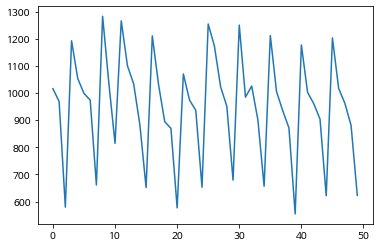

In [6]:
plt.plot(lunch_count_predict)


#### a) 랜덤포레스트 모델 시각화


In [7]:
lunch_model.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=2044468366),
 DecisionTreeRegressor(max_features='auto', random_state=1763300334),
 DecisionTreeRegressor(max_features='auto', random_state=706842912),
 DecisionTreeRegressor(max_features='auto', random_state=1344462311),
 DecisionTreeRegressor(max_features='auto', random_state=982548643),
 DecisionTreeRegressor(max_features='auto', random_state=1709280053),
 DecisionTreeRegressor(max_features='auto', random_state=2046541379),
 DecisionTreeRegressor(max_features='auto', random_state=826260785),
 DecisionTreeRegressor(max_features='auto', random_state=1059396753),
 DecisionTreeRegressor(max_features='auto', random_state=1824441502),
 DecisionTreeRegressor(max_features='auto', random_state=185547038),
 DecisionTreeRegressor(max_features='auto', random_state=1569023234),
 DecisionTreeRegressor(max_features='auto', random_state=1266534795),
 DecisionTreeRegressor(max_features='auto', random_state=1808363502),
 DecisionTreeRegressor(m

0

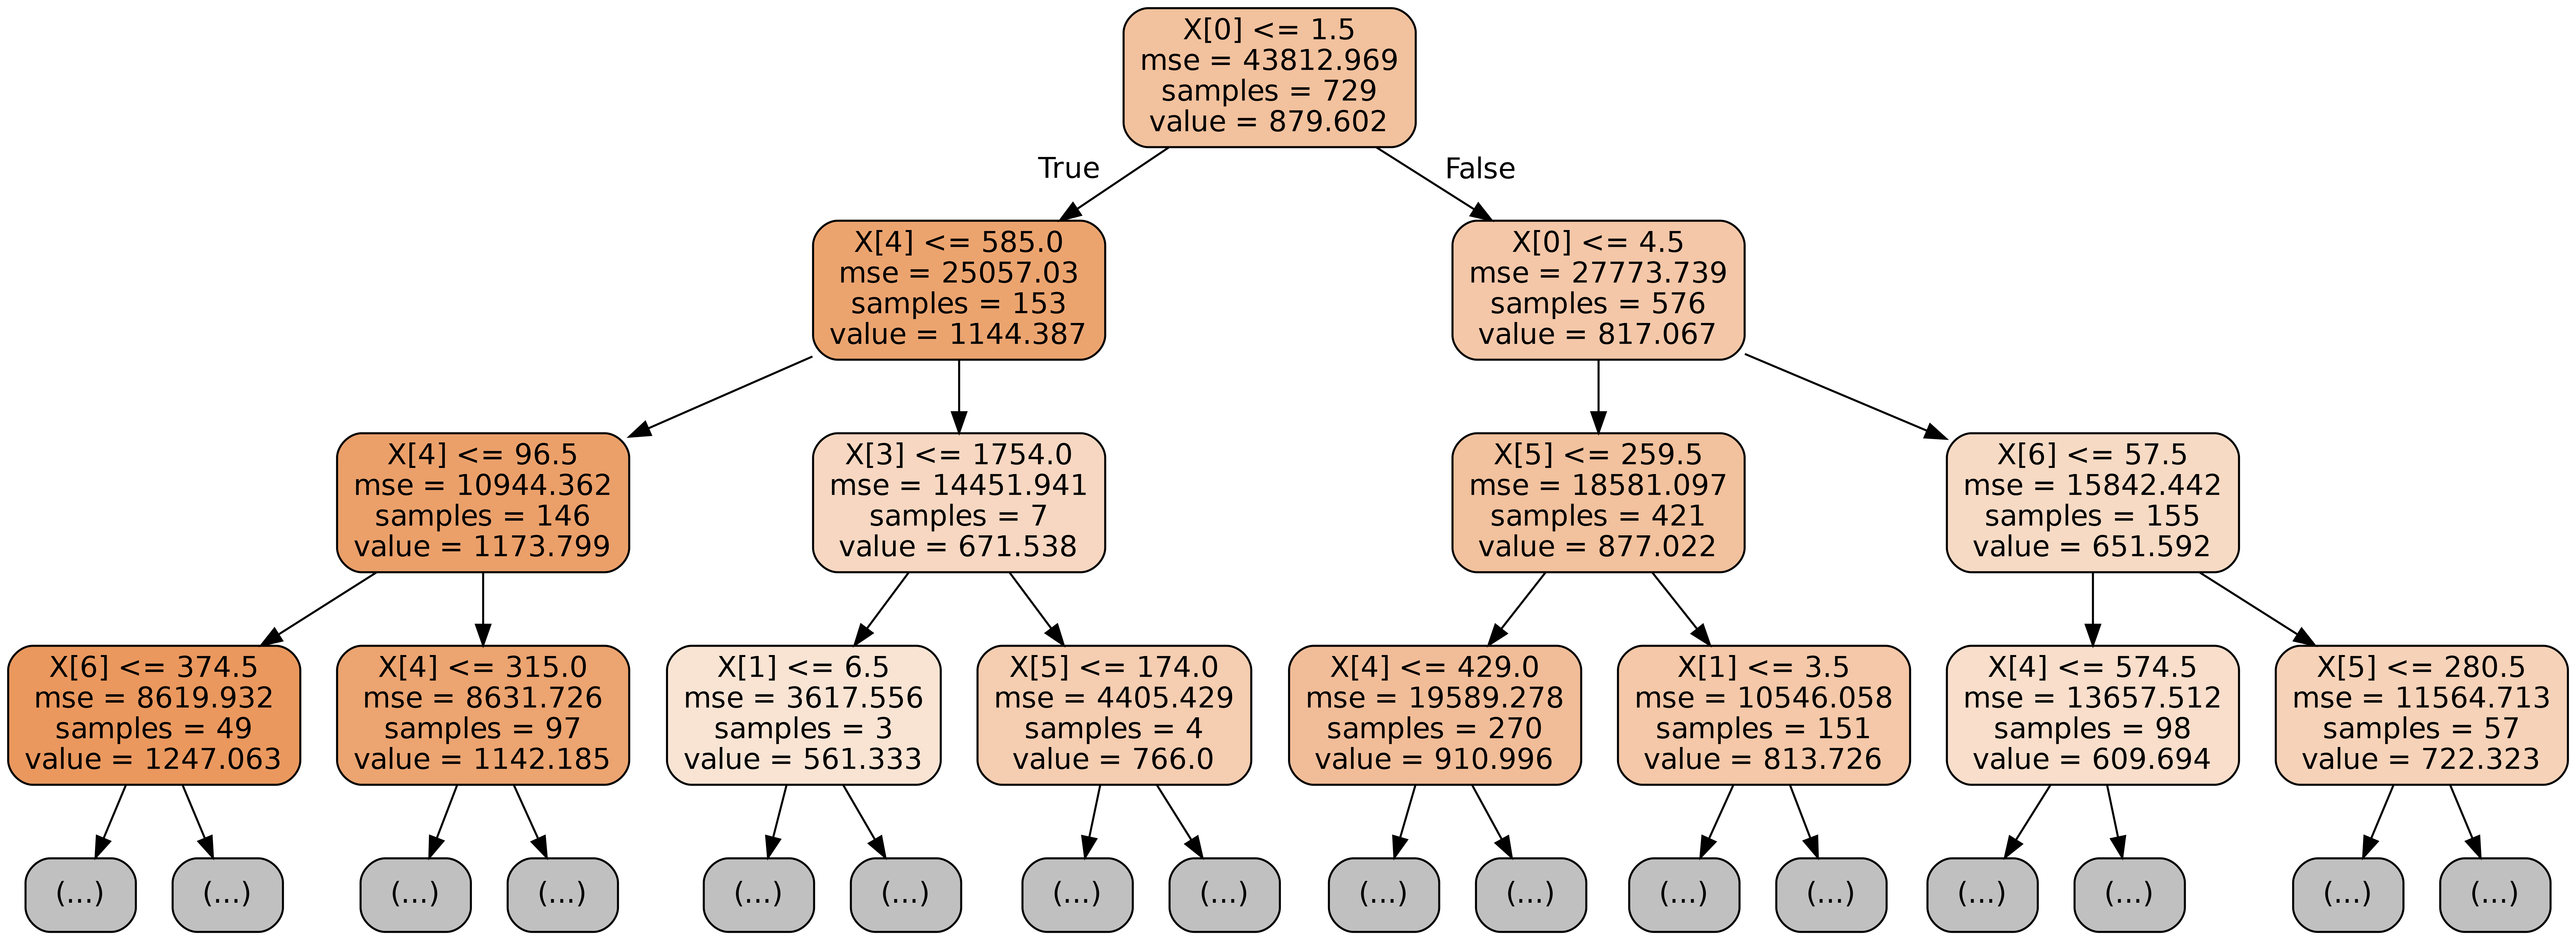

In [8]:
from sklearn.tree import export_graphviz

estimator = lunch_model.estimators_[1]

export_graphviz(estimator, out_file = 'tree.dot',
               max_depth = 3,
               precision = 3,
               filled = True,
               rounded = True)

from subprocess import call

call(['dot', '-Tpng', 'tree.dot', '-o', 'decision-tree.png', '-Gdpi=600'])

from IPython.display import Image

Image(filename = 'decision-tree.png') # rf 안의 하나의 의사결정 나무인 것.

In [9]:
## 강사님 코드
# from sklearn.tree import export_graphviz

# estimator = lunch_model.estimators_[1]

# export_graphviz(estimator, out_file='tree.dot',
#                 max_depth = 3,
#                 precision = 3,
#                 filled=True,
#                 rounded=True
#                 )

# from subprocess import call

# call(['dot', '-Tpng', 'tree.dot', '-o', 'decision-tree.png', '-Gdpi=600'])

# from IPython.display import Image
# Image(filename = 'decision-tree.png')


### 2) 석식계 예측 모델

In [10]:
features.append('중식계')
features

['요일',
 '월',
 '일',
 '현재원',
 '본사휴가자수',
 '본사출장자수',
 '본사시간외근무명령서승인건수',
 '현본사소속재택근무자수',
 '중식계']

In [11]:
test['중식계'] = lunch_count_predict
test

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,월,일,현재원,중식계
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,1,27,2355.0,1015.81
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,1,28,2319.0,968.27
2,2021-01-29,5,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,1,29,2170.0,579.28
3,2021-02-01,1,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2,1,2340.0,1192.36
4,2021-02-02,2,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2,2,2362.0,1053.01
5,2021-02-03,3,2924,59,199,5,286.0,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,2,3,2380.0,998.39
6,2021-02-04,4,2924,61,211,476,288.0,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,2,4,2364.0,973.80
7,2021-02-05,5,2924,169,252,0,256.0,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,2,5,2247.0,660.83
8,2021-02-08,1,2924,88,174,690,329.0,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,2,8,2333.0,1282.79
9,2021-02-09,2,2924,94,183,542,329.0,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,2,9,2318.0,1037.46


In [12]:
X = train[features]
y = train['석식계']

dinner_model = RandomForestRegressor()

dinner_model.fit(X,y)

dinner_count_predict = dinner_model.predict(test[features])

RandomForestRegressor()

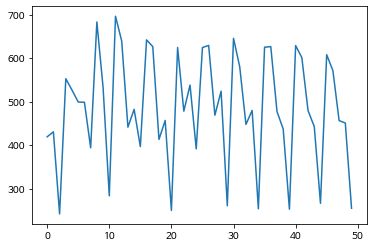

In [13]:
plt.plot(dinner_count_predict)

In [14]:
submission['중식계'] = lunch_count_predict
submission['석식계'] = dinner_count_predict

# submission.to_csv('교육_제출RF.csv', index = False) # 115점, 비정상 (80~90 사이로 점수 나와야함.)

[sklearn 홈페이지 -> regression -> 모델 선택 rf](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

## 3. 하이퍼파라미터 튜닝하기

In [15]:
features = ['요일', '월', '일', '현재원', '본사휴가자수',
      '본사출장자수', '본사시간외근무명령서승인건수',
      '현본사소속재택근무자수']

features

['요일', '월', '일', '현재원', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

In [16]:
# 처음에 안나왔던 내 코드
# features = features[:-1]

X = train[features]
y = train['중식계']
lunch_model = RandomForestRegressor(n_estimators = 200, criterion = 'mae')
# lunch_model = RandomForestRegressor(n_estimators = 200, criterion = 'absolute_error')
lunch_model.fit(X, y)

lunch_count_predict = lunch_model.predict(test[features])

# plt.plot(lunch_count_predict)

RandomForestRegressor(criterion='mae', n_estimators=200)

RandomForestRegressor(criterion='mae', n_estimators=200)

<Figure size 900x600 with 0 Axes>

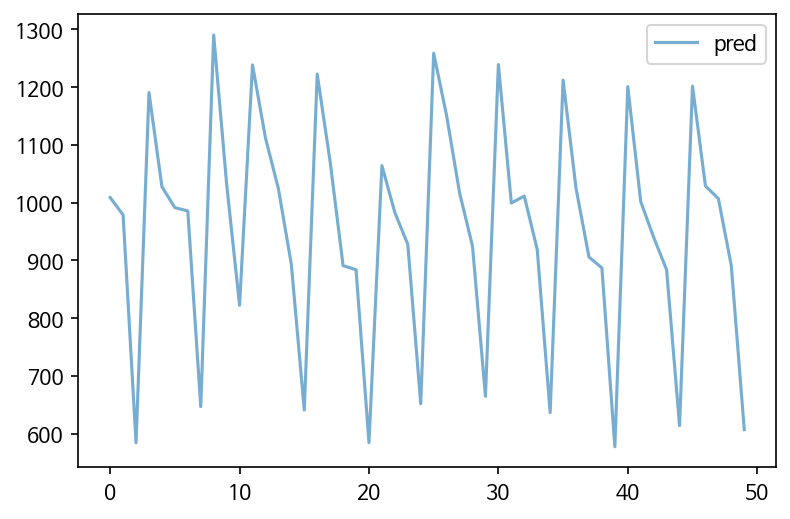

RandomForestRegressor(criterion='mae', n_estimators=200)

<Figure size 900x600 with 0 Axes>

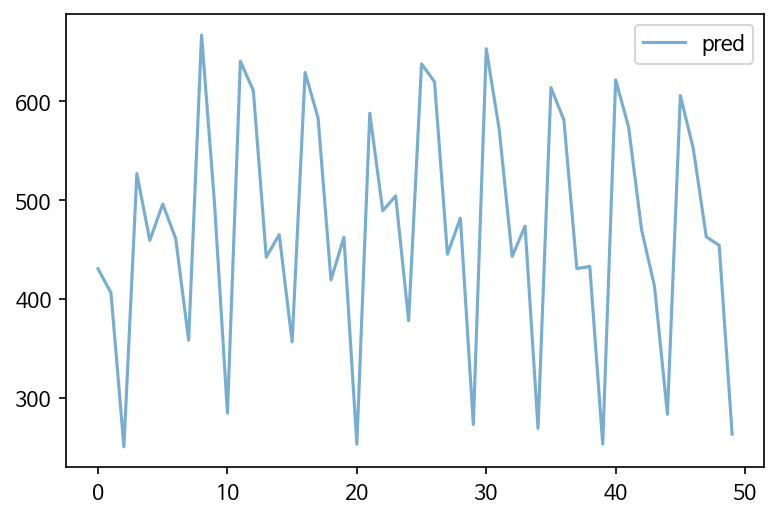

In [17]:
# 강사님 코드
# 중식계

# features = features[:-1]

X = train[features]
y = train['중식계']

from sklearn.ensemble import RandomForestRegressor

lunch_model = RandomForestRegressor(n_estimators=200, criterion='mae')

lunch_model.fit(X,y)

lunch_count_predict = lunch_model.predict(test[features])

plt.figure(dpi=150)
plt.plot(lunch_count_predict, alpha=0.6, label='pred')
plt.legend()
plt.show()

# 석식계

features.append('중식계')

test['중식계'] = lunch_count_predict

X = train[features]
y = train['석식계']

dinner_model = RandomForestRegressor(n_estimators=200, criterion='mae')

dinner_model.fit(X,y)

dinner_count_predict = dinner_model.predict(test[features])

plt.figure(dpi=150)
plt.plot(dinner_count_predict, alpha=0.6, label='pred')
plt.legend()
plt.show()


In [20]:
submission['중식계'] = lunch_count_predict
submission['석식계'] = dinner_count_predict

In [23]:
# submission.to_csv('교육_제출RF2.csv', index = False)

## 4. 텍스트 데이터 사용해보기

In [ ]:
# 제대로 못 본 코드
# def find_something(text:str):
#     if '두루치기' in text:
#         return True
#     else:
#         return False
# x = ['두루치기', 'No 두루치기']
# y = [train[train['중식메뉴'].map(find_something)]['중식계'].mean()]

# plt.figure(dpi = 150)

# plt.xlabel('메뉴')
# plt.ylabel('중식계')
# plt.bar(x,y)
# plt.show()

<Figure size 900x600 with 0 Axes>

Text(0.5, 1.0, '남자들의 소울푸드')

Text(0.5, 0, '메뉴')

Text(0, 0.5, '중식계')

<BarContainer object of 2 artists>

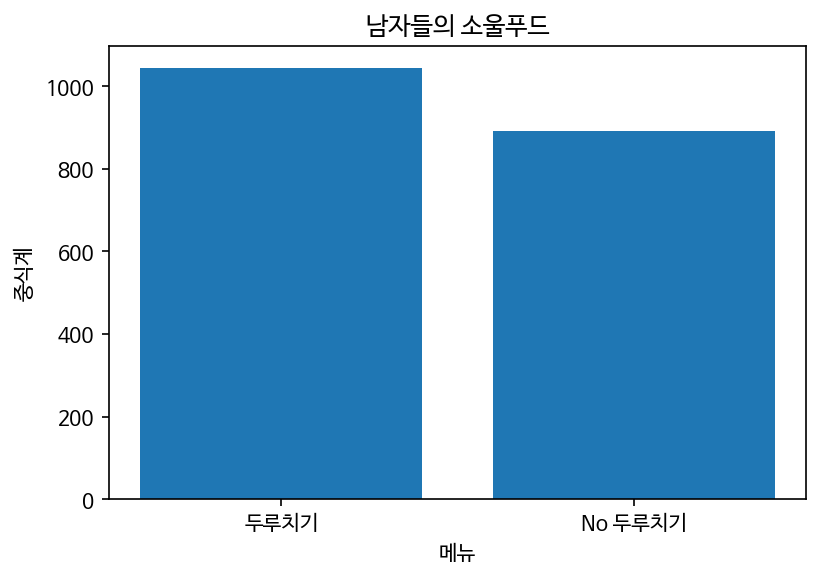

In [18]:
# 강사님 코드
def find_something(text:str):
    if '두루치기' in text:
        return True
    else:
        return False

x = ['두루치기', 'No 두루치기']
y =[train[train['중식메뉴'].map(find_something)]['중식계'].mean(),train[~train['중식메뉴'].map(find_something)]['중식계'].mean()]
plt.figure(dpi=150)
plt.title("남자들의 소울푸드")
plt.xlabel('메뉴')
plt.ylabel('중식계')
plt.bar(x, y)
plt.show()